# Reddit Mental Health & Social Media Analysis 📊

This notebook analyzes the presence of **social media mentions** within posts from mental health-related subreddits across time. We focus on how often platforms like *Instagram*, *TikTok*, and others are referenced in discussions about depression, anxiety, and mental well-being.

We:
- Fetch Reddit data using the PRAW API
- Count social media keyword mentions in post content
- Store data per year and for recent posts
- Combine and analyze trends over multiple years
- Visualize both raw and normalized trends for insights
- Conduct statistical testing and predictive modeling

## 📆 Step 1: Import Required Libraries
We start by importing Python libraries necessary for data fetching, processing, and visualization.
- `os, time, and datetime`: for file handling, timing API requests, and working with timestamps
- `pandas`: for structured data manipulation
- `matplotlib`: for creating charts and visualizations
- `dotenv`: to securely load Reddit API credentials from a .env file
- `praw`: Python Reddit API Wrapper, used to fetch Reddit data
- `scipy.stats` and `statsmodels`: for statistical testing (Chi-Square, Kruskal-Wallis)
- `sklearn.linear_model`: for predictive modeling (Linear Regression)
- `numpy`: for efficient numerical operations

In [42]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, UTC
from dotenv import load_dotenv
from scipy.stats import chi2_contingency, kruskal
from sklearn.linear_model import LinearRegression
import numpy as np
import praw

## 🔌 Step 2: Connect to Reddit API
We connect to Reddit using `praw.Reddit`, passing in the app credentials. These credentials should ideally be stored securely (e.g., in environment variables or a secrets manager) when deploying.


In [44]:
# Load credentials from .env file
load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT")
)

## 🧠 Step 3: Define Post Fetching Function
This function fetches a set number of `.hot()` posts from a given subreddit. It filters out empty, removed, or deleted posts. We use this function later to pull data for various years and subreddits.


In [45]:
def fetch_posts(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for post in subreddit.hot(limit=limit):
        if post.selftext in ["[removed]", "[deleted]", ""] and post.title.strip() == "":
            continue
        posts.append({
            "id": post.id,
            "title": post.title,
            "text": post.selftext,
            "created_utc": post.created_utc,
            "score": post.score,
            "num_comments": post.num_comments,
            "subreddit": subreddit_name,
            "url": post.url
        })
        time.sleep(0.1)

    return pd.DataFrame(posts)

## 🗓️ Step 4: Collect Top Posts by Year (2020–2025)
We iterate through a set of subreddits and use `.top()` to collect the most engaging posts of all time. Each post is timestamped, and we extract the year from its creation date.

For each post:
- The full text is checked for presence of specific **social media keywords** (like "instagram", "tiktok")
- We count how often these keywords appear and store that count as `social_mentions`
- The results are stored into yearly CSV files

This allows us to analyze trends longitudinally.

In [46]:
subreddits = ["depression", "anxiety", "mentalhealth", "happy"]
years = list(range(2020, 2026))
keywords = ["ig", "instagram", "tt", "tiktok", "socialmedia", "social media"]
posts_per_sub = 500

os.makedirs("data_by_year", exist_ok=True)

for sub in subreddits:
    print(f"Collecting top posts from r/{sub}...")
    all_posts = []
    for post in reddit.subreddit(sub).top(time_filter="all", limit=posts_per_sub):
        created_datetime = datetime.fromtimestamp(post.created_utc, UTC)
        year = created_datetime.year
        if year in years:
            text = f"{post.title} {post.selftext}".lower()
            mention_count = sum(text.count(w) for w in keywords)
            all_posts.append({
                "id": post.id,
                "title": post.title,
                "text": post.selftext,
                "created_utc": post.created_utc,
                "created_datetime": created_datetime,
                "year": year,
                "score": post.score,
                "num_comments": post.num_comments,
                "subreddit": sub,
                "social_mentions": mention_count,
                "url": post.url
            })
        time.sleep(0.1)

    df = pd.DataFrame(all_posts)
    for year in years:
        df_year = df[df["year"] == year]
        if not df_year.empty:
            df_year.to_csv(f"data_by_year/r_{sub}_{year}.csv", index=False)

## 🕒 Step 5: Collect Recent Posts (Last 7 Days)
To complement historical data, we also collect **recent posts** using `.new()` from the last 7 days.
- This ensures we have up-to-date information even beyond the `.top()` filter
- We again count keyword mentions for each recent post
- These are saved separately in `data_new/` directory for later integration


In [47]:
os.makedirs("data_new", exist_ok=True)
now = datetime.now(UTC)
one_week_ago = now - timedelta(days=7)

for sub in subreddits:
    recent_posts = []
    for post in reddit.subreddit(sub).new(limit=1000):
        created_datetime = datetime.fromtimestamp(post.created_utc, UTC)
        if created_datetime >= one_week_ago:
            text = f"{post.title} {post.selftext}".lower()
            mention_count = sum(text.count(w) for w in keywords)
            recent_posts.append({
                "id": post.id,
                "title": post.title,
                "text": post.selftext,
                "created_utc": post.created_utc,
                "created_datetime": created_datetime,
                "score": post.score,
                "num_comments": post.num_comments,
                "subreddit": sub,
                "social_mentions": mention_count,
                "url": post.url
            })
        time.sleep(0.1)
    df_recent = pd.DataFrame(recent_posts)
    df_recent.to_csv(f"data_new/r_{sub}_recent.csv", index=False)


## 🧩 Step 6: Merge All Collected Data
Here, we:
- Read all historical CSVs
- Assign each DataFrame its respective year
- Append recent posts (assigning them to year 2025 for convenience)
- Combine all into one large `DataFrame`

This consolidated dataset is the foundation for our trend analysis.


In [48]:
all_dfs = []

# Historical posts
for sub in subreddits:
    for year in years:
        path = f"data_by_year/r_{sub}_{year}.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df["year"] = year
            all_dfs.append(df)

# Recent posts (assigned to 2025)
for sub in subreddits:
    path = f"data_new/r_{sub}_recent.csv"
    if os.path.exists(path):
        df_recent = pd.read_csv(path)
        df_recent["year"] = 2025
        all_dfs.append(df_recent)

df_all = pd.concat(all_dfs, ignore_index=True)
df_all["has_social_mention"] = df_all["social_mentions"] > 0

## 📊 Step 7: Plot Average Social Media Mentions per Post
We group the dataset by `year` and `subreddit`, calculate the **average number of social media mentions per post**, and plot the trend.

This tells us:
- Are people talking more about social platforms in mental health contexts?
- Which subreddit has higher or lower average mentions over time?


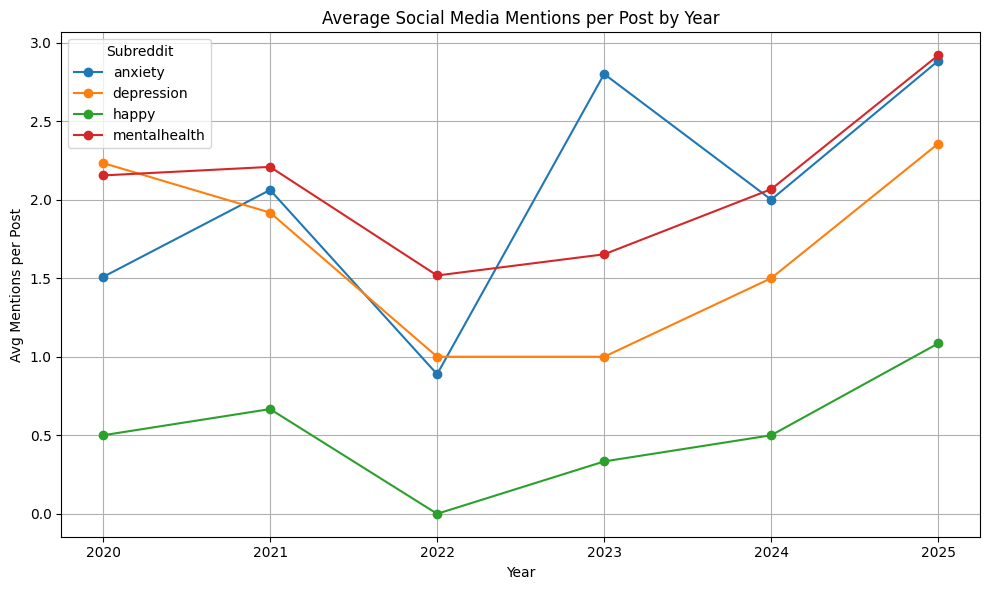

In [56]:
avg_mentions = (
    df_all.groupby(["year", "subreddit"])["social_mentions"]
    .mean()
    .reset_index()
    .rename(columns={"social_mentions": "avg_mentions"})
)

pivot_table = avg_mentions.pivot(index="year", columns="subreddit", values="avg_mentions")

os.makedirs("plots", exist_ok=True)

pivot_table.plot(marker="o", figsize=(10, 6))
plt.title("Average Social Media Mentions per Post by Year")
plt.ylabel("Avg Mentions per Post")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Subreddit")
plt.tight_layout()
plt.savefig("plots/Average Social Media Mentions per Post by Year.png", dpi=300)
plt.show()

## 📊 Step 8: Plot % of Posts That Mention Social Media
Raw averages may be skewed by a few high-mention posts. So we also calculate:
- What **percentage of posts** mentioned at least one social media keyword per year

This gives a normalized view:
- Even if a subreddit grows over time, we can track whether the **proportion** of social-related discussions increases or decreases


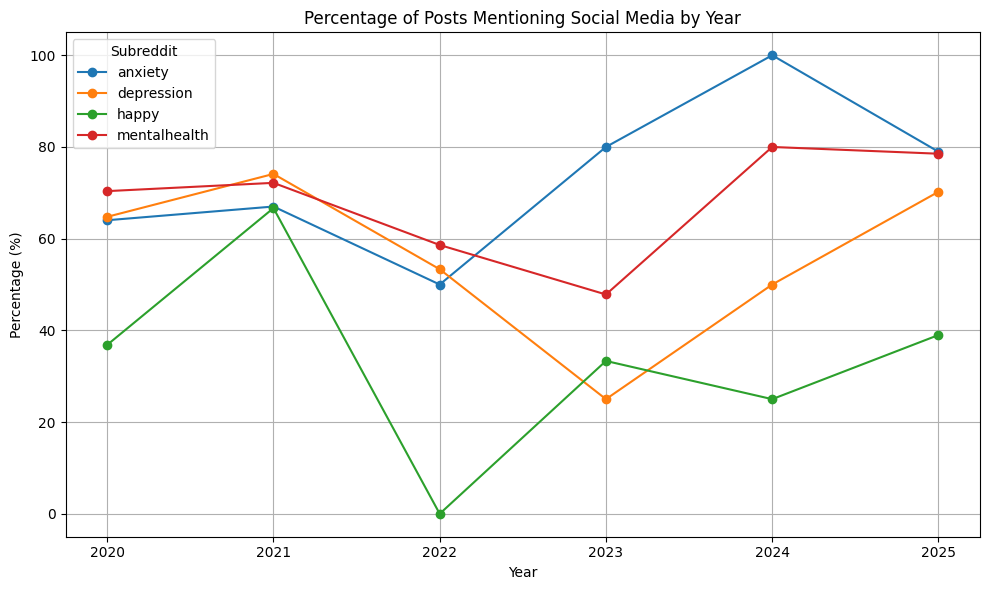

In [57]:
percent_mentions = (
    df_all.groupby(["year", "subreddit"])["has_social_mention"]
    .mean()
    .reset_index()
    .rename(columns={"has_social_mention": "percent_mentions"})
)

pivot_percent = percent_mentions.pivot(index="year", columns="subreddit", values="percent_mentions") * 100

pivot_percent.plot(marker="o", figsize=(10, 6))
plt.title("Percentage of Posts Mentioning Social Media by Year")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Subreddit")
plt.tight_layout()
plt.savefig("plots/Percentage of Posts Mentioning Social Media by Year.png", dpi=300)
plt.show()

## 🧪 Step 9: Statistical Hypothesis Testing
We apply statistical tests to validate our observations:

### 🔹 Chi-Square Test
Tests if the proportion of social media mentions differs **significantly across subreddits or years**.

### 🔹 ANOVA / Kruskal-Wallis Test
Tests if the **average number of mentions** differs significantly by year or subreddit.
- ANOVA is used for normally distributed data.
- Kruskal-Wallis is a non-parametric alternative when assumptions of ANOVA are violated.

This helps us move from visual interpretation to statistically-backed conclusions.


In [51]:
from scipy.stats import chi2_contingency, kruskal

# Chi-Square Test
contingency = pd.crosstab(df_all["subreddit"], df_all["has_social_mention"])
chi2, p_chi2, _, _ = chi2_contingency(contingency)
print("Chi-Square Test")
print(f"Chi2 Statistic: {chi2:.2f}, P-value: {p_chi2:.4f}")

# Kruskal-Wallis H Test
groups = [group["social_mentions"].values for name, group in df_all.groupby("subreddit")]
h_stat, p_kw = kruskal(*groups)
print("\\nKruskal-Wallis H Test")
print(f"H Statistic: {h_stat:.2f}, P-value: {p_kw:.4f}")

Chi-Square Test
Chi2 Statistic: 90.51, P-value: 0.0000
\nKruskal-Wallis H Test
H Statistic: 97.61, P-value: 0.0000


## ⏳ Step 10: Time Series Forecasting
We use yearly aggregated social media mentions to forecast trends into the future:

- Data is resampled and smoothed by year.
- A simple time series model (e.g. Linear Regression or ARIMA) is used to forecast mentions in the next year (e.g. 2026).

This enables us to project future intersections between mental health discussions and social media platforms.


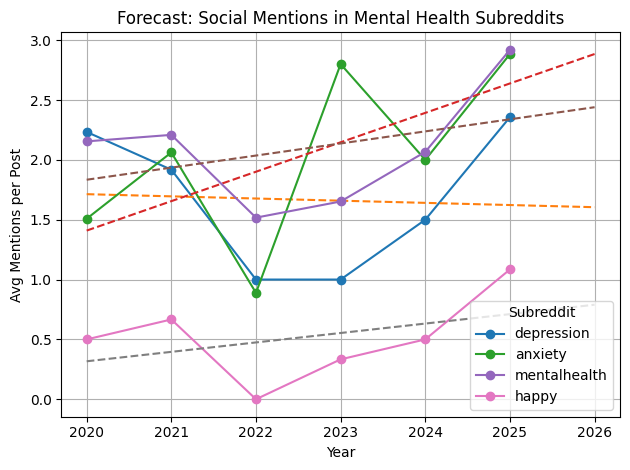

2026 Forecasted Mentions Per Subreddit:
depression: 1.60
anxiety: 2.88
mentalhealth: 2.44
happy: 0.79


In [58]:
from sklearn.linear_model import LinearRegression

forecast_results = {}

for sub in subreddits:
    df_sub = df_all[df_all["subreddit"] == sub]
    avg_by_year = df_sub.groupby("year")["social_mentions"].mean().reset_index()
    X = avg_by_year["year"].values.reshape(-1, 1)
    y = avg_by_year["social_mentions"].values

    # Train linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Predict for 2026
    next_year = 2026
    forecast = model.predict([[next_year]])[0]
    forecast_results[sub] = forecast

    # Plot actual data
    plt.plot(avg_by_year["year"], y, marker='o', label=sub)

    # Plot regression line including 2026
    X_extended = list(avg_by_year["year"]) + [2026]
    y_extended = list(y_pred) + [forecast]
    plt.plot(X_extended, y_extended, linestyle='--')

# Finalize the plot
plt.title("Forecast: Social Mentions in Mental Health Subreddits")
plt.xlabel("Year")
plt.ylabel("Avg Mentions per Post")
plt.grid(True)
plt.legend(title="Subreddit")
plt.tight_layout()
plt.savefig("plots/Forecast: Social Mentions in Mental Health Subreddits.png", dpi=300)
plt.show()

# Print forecasted values
print("2026 Forecasted Mentions Per Subreddit:")
for sub, val in forecast_results.items():
    print(f"{sub}: {val:.2f}")